# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.310786,True,7.734083
1,1.754296,True,8.681555
2,-0.031483,False,0.492589
3,0.191160,True,5.578564
4,-0.053362,True,5.022830
...,...,...,...
995,1.365118,True,8.040369
996,1.879906,True,10.448775
997,0.135907,False,-0.565469
998,-0.731910,True,2.942817


<AxesSubplot: xlabel='v0'>

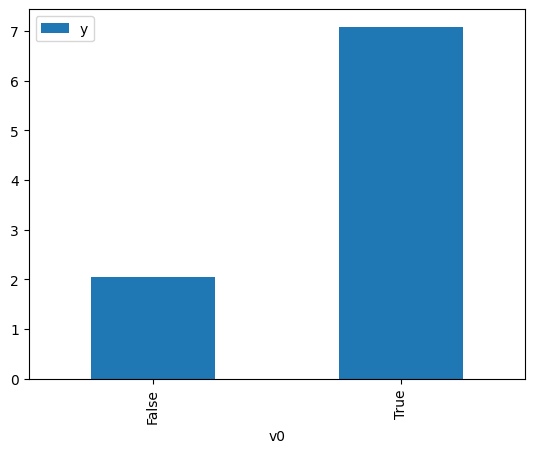

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

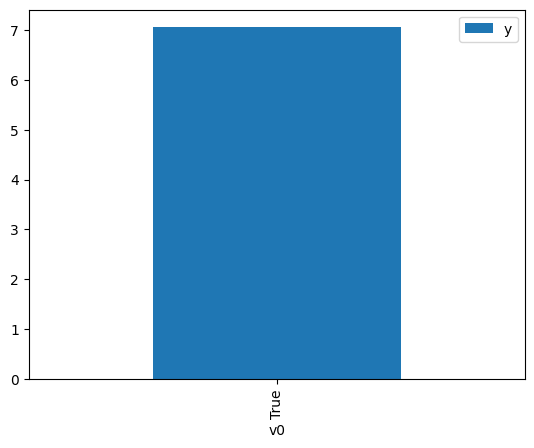

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.581001,False,1.572117,0.255497,3.913944
1,0.516534,False,0.557598,0.275166,3.634174
2,0.516534,False,0.557598,0.275166,3.634174
3,0.778755,False,1.232529,0.201148,4.971471
4,2.148780,False,3.487100,0.028631,34.927371
...,...,...,...,...,...
995,1.363757,False,2.336542,0.091530,10.925331
996,0.125826,False,-0.278460,0.411728,2.428789
997,0.805005,False,2.735049,0.194624,5.138100
998,1.724723,False,5.056132,0.054153,18.466161


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.108903,True,10.119942,0.969581,1.031374
1,-0.562650,True,4.083779,0.327142,3.056776
2,1.095287,True,6.876324,0.867006,1.153395
3,2.375665,True,10.499582,0.979756,1.020662
4,1.169686,True,8.701656,0.879873,1.136528
...,...,...,...,...,...
995,1.762711,True,9.246608,0.948814,1.053948
996,0.568503,True,6.923311,0.740763,1.349959
997,1.969372,True,8.864908,0.962432,1.039034
998,1.226189,True,7.424331,0.888914,1.124968


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          2.550e+04
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:58:06   Log-Likelihood:                         -1421.2
No. Observations:                1000   AIC:                                      2846.
Df Residuals:                     998   BIC:                                      2856.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4480      0.037     66.887      0.000       2.376       2.520
x2             4.9973      0.057     87.942      0.000       4.886       5.109
==============================================================================
Omnibus:                        2.095   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                2.127
Skew:                           0.083   Prob(JB):                        0.345
Kurtosis:                       2.848   Cond. No.                         3.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""